In [1]:
from fastbook import *
from fastai import *
from pathlib import Path
from jmd_imagescraper.core import *
from jmd_imagescraper.imagecleaner import *

In [2]:
### CONSTANTS
IMG_LOC = Path("./images")

In [3]:
### Uncomment this cell to re-run the query and download new images
# to_query = ['guitar', 'bass']

# for item in to_query:
#     results = duckduckgo_search(IMG_LOC, item, f'electric {item}', max_results=300)

# display_image_cleaner(IMG_LOC)

In [4]:
# Verifying that no images are corrupted
verify_images(get_image_files(IMG_LOC))

(#0) []

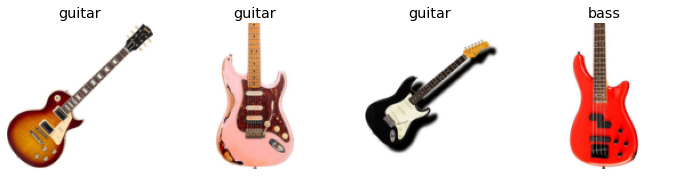

In [5]:
# Create the DataBlock object with the right config for our setup:
# images + category labels
# 20% of set used for validation with random selection
# target label is in the parent folder of the images
# resize them all to 128 pixels
instruments = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

# Load images given above config and path
dls = instruments.dataloaders(IMG_LOC)

# Show a batch of examples for human validation
dls.valid.show_batch(max_n=4, nrows=1)

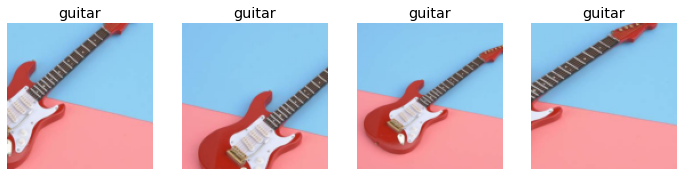

In [6]:
# During resizing, the image may get cropped and important details can be left out
# We can avoid this by cropping different parts of the image at different epochs
instruments = instruments.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = instruments.dataloaders(IMG_LOC)
dls.train.show_batch(max_n=4, nrows=1, unique=True) # use unique to show crops of the same image

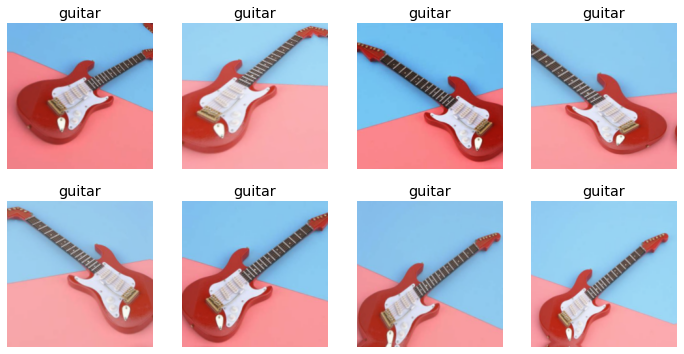

In [7]:
# Likely we want to add even more data augmentation to make the model more robust
# The aug_transforms() function automatically creates rotated, perspective warped etc. versions of the image
instruments = instruments.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = instruments.dataloaders(IMG_LOC)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [8]:
# Use a pre-trained vision learner model and fine-tune it to our use-case
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.068846,0.376837,0.166667,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.566667,0.278149,0.140351,00:03
1,0.454457,0.221202,0.087719,00:03
2,0.394240,0.194878,0.070175,00:03
3,0.317933,0.172369,0.070175,00:03
4,0.266630,0.128558,0.070175,00:03
5,0.215995,0.118579,0.052632,00:03
6,0.185027,0.092565,0.052632,00:03
7,0.159825,0.088952,0.035088,00:03
8,0.136524,0.087445,0.026316,00:03
9,0.120334,0.086454,0.035088,00:03


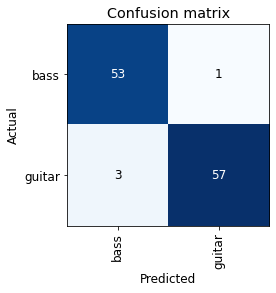

In [9]:
# Visualize classification error using confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

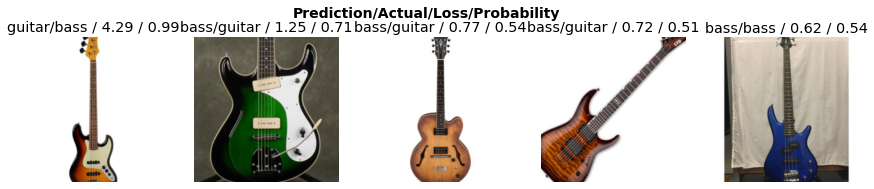

In [10]:
# Which images were misclassified / toughest to classify correctly?
interp.plot_top_losses(5, nrows=1)

In [12]:
# Export model as pickle file, by default called 'export.pkl'
learn.export()

In [13]:
# Load in a model using load_learner
learn_inf = load_learner('export.pkl')

In [14]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [15]:
img = PILImage.create(btn_upload.data[-1])

In [18]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(224,224))
out_pl

Output()

In [19]:
pred,pred_idx,probs = learn_inf.predict(img)

In [21]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: guitar; Probability: 0.9997')

In [22]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [24]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(224,224))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probabiliy: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [27]:
btn_upload = widgets.FileUpload()

In [29]:
from ipywidgets import VBox
VBox([widgets.Label('Select your instrument!'),
      btn_upload, btn_run, out_pl, lbl_pred])